### [Ordinal Models and Decision Policies for Predictive Maintenance](https://medium.com/@kylejones_47003/ordinal-models-and-decision-policies-for-predictive-maintenance-as-an-alternative-to-estimating-rul-843a577540f1)

In predictive maintenance, estimating an asset’s **Remaining Useful Life (RUL)** lets organizations plan servicing and avoid unplanned downtime. However, RUL forecasts can be difficult to interpret in operational settings where decisions must be made under uncertainty. In this project, we convert RUL estimates into discrete health states. This approach offers interpretability, consistency, and a natural bridge to action.

Demonstrating how to transition from continuous degradation tracking to categorical health modeling using ordinal classification.

- **Healthy (RUL > 30 cycles)**
- **Warning (11 ≤ RUL ≤ 30)**
- **Distress (RUL ≤ 10)**

Compare three deep learning approaches to ordinal prediction:

- **Scalar Regression (MSE):** A standard LSTM regressor is trained to predict a scalar value representing the ordinal label. Although the model minimizes mean squared error, it ignores the structure and ordering of the categories.

- **CORN (Conditional Ordinal Regression for Neural networks):** This method models ordinal categories as a sequence of binary decisions and uses a dedicated ordinal loss function. It preserves order structure and enables better calibration.

- **CORAL (Cumulative Ordinal Regression using a Logistic Link):** CORAL integrates a cumulative ordinal regression layer into the neural architecture. It explicitly models cumulative probabilities of being above a given threshold, offering a principled treatment of ordinal constraints.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas statsmodels scikit-learn matplotlib
!pip install -q coral-pytorch torch "tensorflow==2.18.0"

  You can safely remove it manually.
  You can safely remove it manually.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time
from coral_pytorch.losses import coral_loss
from coral_pytorch.losses import corn_loss
from coral_pytorch.dataset import levels_from_labelbatch, proba_to_label
from coral_pytorch.layers import CoralLayer
from coral_pytorch.dataset import corn_label_from_logits

plt.rcParams.update({
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.edgecolor": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.0,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

In [4]:
# --------- Load FD003 and Process ---------
df = pd.read_csv("https://raw.githubusercontent.com/edwardzjl/CMAPSSData/refs/heads/master/train_FD003.txt", sep='\\s+', header=None)
cols = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
df.columns = cols
rul = df.groupby('unit')['cycle'].max().reset_index()
rul.columns = ['unit', 'max_cycle']
df = df.merge(rul, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df['HealthState'] = pd.cut(df['RUL'], bins=[-1, 10, 30, np.inf], labels=[2, 1, 0]).astype(int)

sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

In [5]:
df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,max_cycle,RUL,HealthState
0,1,1,-0.0005,0.0004,100.0,0.0,0.355972,0.370523,0.308580,0.0,...,0.647755,0.0,0.272727,0.0,0.0,0.559524,0.446331,259,258,0
1,1,2,0.0008,-0.0003,100.0,0.0,0.388759,0.399100,0.309360,0.0,...,0.685659,0.0,0.363636,0.0,0.0,0.488095,0.534836,259,257,0
2,1,3,-0.0014,-0.0002,100.0,0.0,0.313817,0.353298,0.445398,0.0,...,0.564462,0.0,0.272727,0.0,0.0,0.404762,0.458577,259,256,0
3,1,4,-0.0020,0.0001,100.0,0.0,0.487119,0.417107,0.237285,0.0,...,0.558909,0.0,0.363636,0.0,0.0,0.470238,0.391966,259,255,0
4,1,5,0.0016,0.0000,100.0,0.0,0.196721,0.476218,0.321217,0.0,...,0.556736,0.0,0.363636,0.0,0.0,0.577381,0.543371,259,254,0


In [6]:
# --------- Dataset ---------
class TurbofanDataset(Dataset):
    def __init__(self, df, seq_len=30):
        X, y = [], []
        for unit in df['unit'].unique():
            unit_df = df[df['unit'] == unit].sort_values('cycle')
            X_vals = unit_df[sensor_cols].values
            y_vals = unit_df['HealthState'].values
            for i in range(len(X_vals) - seq_len):
                X.append(X_vals[i:i+seq_len])
                y.append(y_vals[i+seq_len])
        self.X = torch.tensor(np.array(X), dtype=torch.float32)
        self.y = torch.tensor(np.array(y), dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

dataset = TurbofanDataset(df)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
# --------- Base LSTM ---------
class LSTMBackbone(nn.Module):
    def __init__(self, input_size=21, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_size = hidden_size
    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return h[-1]

# --------- Models ---------
class MSEModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.backbone = LSTMBackbone()
        self.out = nn.Linear(self.backbone.hidden_size, 1)
    def forward(self, x): return self.out(self.backbone(x))

class CORNModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.backbone = LSTMBackbone()
        self.out = nn.Linear(self.backbone.hidden_size, 2)
    def forward(self, x): return self.out(self.backbone(x))

class CORALModel(nn.Module):
    def __init__(self): 
        super().__init__()
        self.backbone = LSTMBackbone()
        self.coral = CoralLayer(self.backbone.hidden_size, 3)
    def forward(self, x):
        logits = self.coral(self.backbone(x))
        return logits, torch.sigmoid(logits)

In [8]:
# --------- Unified Training Function ---------
def train(model, loss_fn, output_fn, is_coral=False, epochs=20):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_hist, mse_hist = [], []
    for epoch in range(epochs):
        model.train()
        total_loss, total_mse, count = 0, 0, 0
        for X_batch, y_batch in loader:
            y_batch = y_batch.to(torch.long)
            if is_coral:
                logits, probas = model(X_batch)
                levels = levels_from_labelbatch(y_batch, 3).float()
                loss = coral_loss(logits, levels)
                preds = output_fn(probas)
            else:
                logits = model(X_batch)
                if loss_fn == corn_loss:
                    loss = loss_fn(logits, y_batch, 3)
                    preds = output_fn(logits)
                else:
                    loss = loss_fn(logits.squeeze(), y_batch.float())
                    preds = logits.squeeze()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_mse += ((preds.clamp(0, 2).round() - y_batch.float())**2).sum().item()
            count += y_batch.size(0)
        loss_hist.append(total_loss)
        mse_hist.append(total_mse / count)
        print(f"Epoch {epoch+1:2d}: Loss={total_loss:.4f}, MSE={total_mse / count:.4f}")
    return loss_hist, mse_hist

In [9]:
# --------- Train All Three Models ---------
print("--- Scalar MSE ---")
mse_model = MSEModel()
start = time.time()
mse_loss, mse_mse = train(mse_model, nn.MSELoss(), lambda x: x.squeeze())
mse_time = time.time() - start
print(f"MSE time: {mse_time}")

print("--- CORN ---")
corn_model = CORNModel()
start = time.time()
corn_loss_hist, corn_mse = train(corn_model, corn_loss, lambda x: corn_label_from_logits(x).float())
corn_time = time.time() - start
print(f"CORN time: {corn_time}")

print("--- CORAL ---")
coral_model = CORALModel()
start = time.time()
coral_loss_hist, coral_mse = train(coral_model, coral_loss, lambda x: proba_to_label(x).float(), is_coral=True)
coral_time = time.time() - start
print(f"CORAL time: {coral_time}")

--- Scalar MSE ---
Epoch  1: Loss=27.1329, MSE=0.0977
Epoch  2: Loss=13.4869, MSE=0.0529
Epoch  3: Loss=11.4334, MSE=0.0455
Epoch  4: Loss=11.1444, MSE=0.0431
Epoch  5: Loss=10.3406, MSE=0.0399
Epoch  6: Loss=10.1594, MSE=0.0395
Epoch  7: Loss=9.8524, MSE=0.0379
Epoch  8: Loss=10.2499, MSE=0.0409
Epoch  9: Loss=9.7233, MSE=0.0378
Epoch 10: Loss=9.4383, MSE=0.0363
Epoch 11: Loss=9.3181, MSE=0.0362
Epoch 12: Loss=9.2243, MSE=0.0355
Epoch 13: Loss=9.2036, MSE=0.0349
Epoch 14: Loss=9.1198, MSE=0.0345
Epoch 15: Loss=9.3019, MSE=0.0360
Epoch 16: Loss=8.8829, MSE=0.0334
Epoch 17: Loss=8.8337, MSE=0.0345
Epoch 18: Loss=8.7868, MSE=0.0341
Epoch 19: Loss=8.4393, MSE=0.0326
Epoch 20: Loss=8.5051, MSE=0.0331
MSE time: 261.27142906188965
--- CORN ---
Epoch  1: Loss=101.1307, MSE=0.1961
Epoch  2: Loss=52.3568, MSE=0.0750
Epoch  3: Loss=41.0214, MSE=0.0566
Epoch  4: Loss=37.8600, MSE=0.0518
Epoch  5: Loss=34.3124, MSE=0.0460
Epoch  6: Loss=32.7509, MSE=0.0454
Epoch  7: Loss=31.0383, MSE=0.0436
Epoch 

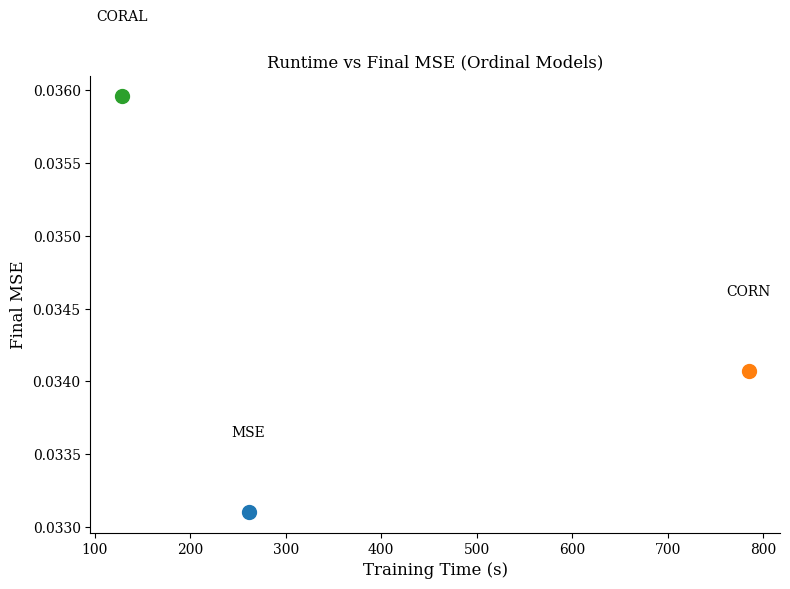

In [10]:
# --------- Plot Comparison ---------
labels = ["MSE", "CORN", "CORAL"]
times = [mse_time, corn_time, coral_time]
mses = [mse_mse[-1], corn_mse[-1], coral_mse[-1]]

plt.figure(figsize=(8, 6))
for label, t, m in zip(labels, times, mses):
    plt.scatter(t, m, s=100, label=label)
    plt.text(t, m + 0.0005, label, ha='center', va='bottom', fontsize=10)

plt.title("Runtime vs Final MSE (Ordinal Models)")
plt.xlabel("Training Time (s)")
plt.ylabel("Final MSE")
plt.grid(False)
plt.tight_layout()
# plt.savefig("final_runtime_vs_mse.png")
plt.show()

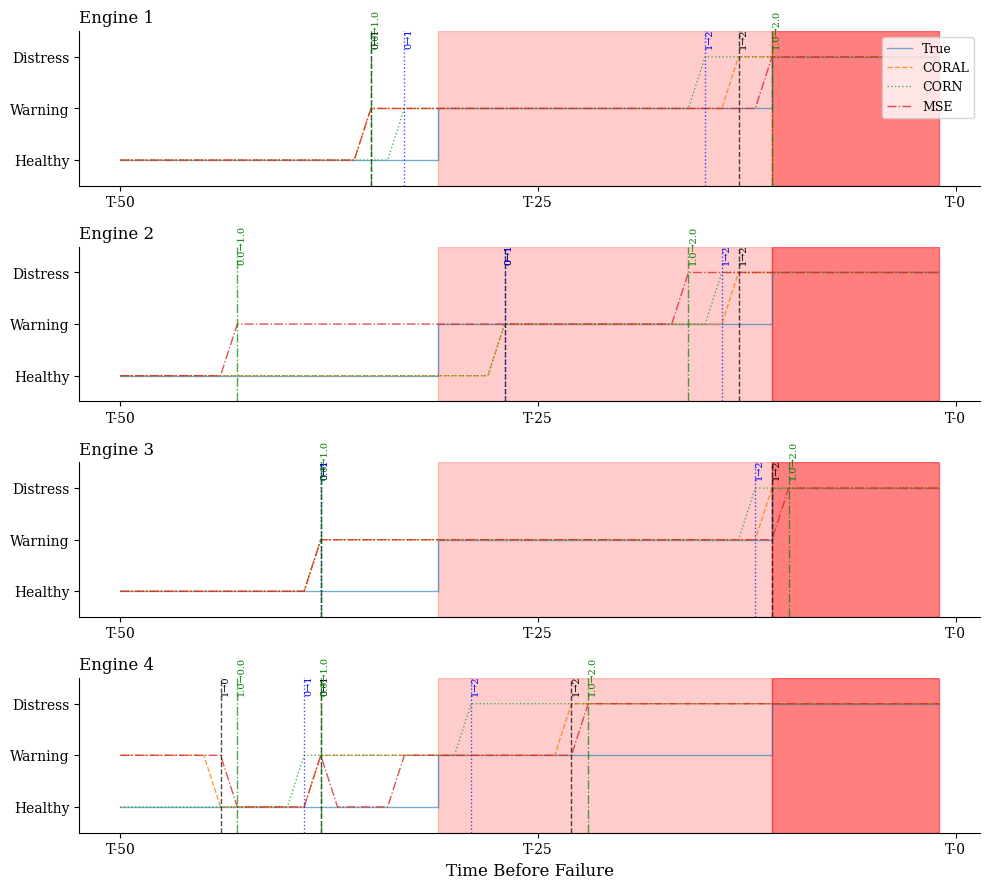

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/edwardzjl/CMAPSSData/refs/heads/master/train_FD003.txt", sep='\\s+', header=None)
cols = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)]
df.columns = cols
rul = df.groupby('unit')['cycle'].max().reset_index()
rul.columns = ['unit', 'max_cycle']
df = df.merge(rul, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df['HealthState'] = pd.cut(df['RUL'], bins=[-1, 10, 30, np.inf], labels=[2, 1, 0]).astype(int)

sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

def get_transitions(preds, min_gap=3):
    transitions = []
    last_idx = -min_gap
    for i in range(1, len(preds)):
        if preds[i] != preds[i-1] and (i - last_idx) >= min_gap:
            transitions.append((i, preds[i-1], preds[i]))
            last_idx = i
    return transitions

def get_state_blocks(y_vals, x_vals):
    blocks = []
    current = y_vals[0]
    start = x_vals[0]
    for i in range(1, len(y_vals)):
        if y_vals[i] != current:
            blocks.append((current, start, x_vals[i]))
            start = x_vals[i]
            current = y_vals[i]
    blocks.append((current, start, x_vals[-1]))
    return blocks

units = df['unit'].unique()[:4]
fig, axes = plt.subplots(len(units), 1, figsize=(10, 9), sharex=False)

for idx, unit in enumerate(units):
    ax = axes[idx]
    unit_df = df[df['unit'] == unit].sort_values('cycle')
    X = torch.tensor(unit_df[sensor_cols].values, dtype=torch.float32)
    cycles = unit_df['cycle'].values
    true_labels = unit_df['HealthState'].values
    seq_len = 30
    X_seq = torch.stack([X[i:i+seq_len] for i in range(len(X)-seq_len)])
    t_cycles = cycles[seq_len:]
    t_labels = true_labels[seq_len:]

    def predict_states(model, is_coral=False, is_corn=False):
        model.eval()
        with torch.no_grad():
            if is_coral:
                logits, probas = model(X_seq)
                pred = torch.sum(probas > 0.5, dim=1).numpy()
            elif is_corn:
                logits = model(X_seq)
                pred = torch.sum(torch.sigmoid(logits) > 0.5, dim=1).numpy()
            else:
                logits = model(X_seq)
                pred = torch.clamp(logits.squeeze(), 0, 2).round().numpy()
        return pred

    coral_pred = predict_states(coral_model, is_coral=True)
    corn_pred = predict_states(corn_model, is_corn=True)
    mse_pred = predict_states(mse_model)

    end_idx = len(t_cycles)
    start_idx = max(0, end_idx - 50)
    x_range = np.array(list(range(-50, 0)))

    y_true = t_labels[start_idx:end_idx]
    y_coral = coral_pred[start_idx:end_idx]
    y_corn = corn_pred[start_idx:end_idx]
    y_mse = mse_pred[start_idx:end_idx]

    def shade_blocks(ax, y_vals, x_vals):
        blocks = get_state_blocks(y_vals, x_vals)
        for val, start, end in blocks:
            if val == 1:
                ax.axvspan(start, end, color='red', alpha=0.2)
            elif val == 2:
                ax.axvspan(start, end, color='red', alpha=0.5)

    ax.plot(x_range, y_true, label='True', drawstyle='steps-post', alpha=0.6)
    ax.plot(x_range, y_coral, label='CORAL', linestyle='--', alpha=0.8)
    ax.plot(x_range, y_corn, label='CORN', linestyle=':', alpha=0.8)
    ax.plot(x_range, y_mse, label='MSE', linestyle='-.', alpha=0.8)

    shade_blocks(ax, y_true, x_range)

    def add_vlines(ax, pred, x_vals, label, color, linestyle):
        shown_transitions = set()
        for i, f, t in get_transitions(pred):
            trans_label = f"{f}→{t}"
            if trans_label not in shown_transitions:
                ax.axvline(x_vals[i], color=color, linestyle=linestyle, alpha=0.7)
                ax.text(x_vals[i], 2.2, trans_label, rotation=90, fontsize=7, color=color)
                shown_transitions.add(trans_label)

    add_vlines(ax, y_coral, x_range, "CORAL", "black", "--")
    add_vlines(ax, y_corn, x_range, "CORN", "blue", ":")
    add_vlines(ax, y_mse, x_range, "MSE", "green", "-.")

    ax.set_title(f"Engine {unit}", loc='left', fontsize=12)
    ax.set_ylim(-0.5, 2.5)
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(["Healthy", "Warning", "Distress"])
    ax.set_xticks([-50, -25, 0])
    ax.set_xticklabels(["T-50", "T-25", "T-0"])
    if idx == len(units) - 1:
        ax.set_xlabel("Time Before Failure")
    if idx == 0:
        ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
# plt.savefig("health_transitions_final.png", dpi=300)
plt.show()

##### Decision Policy Based on Predictions

Predictions are only useful if they lead to better decisions. To demonstrate this, we introduce a simple policy that maps predicted health states to operational actions:

- If a model predicts a Distress state (2), initiate an immediate intervention.
- If the predicted state increases from Healthy (0) to Warning (1), flag the engine for review.
- In all other cases, continue monitoring (“wait”).

In [12]:
np.random.seed(42)
units = df['unit'].unique()
simulated_records = []

for unit in units:
    unit_df = df[df['unit'] == unit].sort_values('cycle')
    if len(unit_df) < 80:  # ensure at least seq_len + 50
        continue
    cycles = unit_df['cycle'].values[-50:]
    rul = unit_df['RUL'].values[-50:]
    true = unit_df['HealthState'].values[-50:]

    for model_name in ['MSE', 'CORN', 'CORAL']:
        # simulate predictions with some randomness around true labels
        noise = np.random.choice([-1, 0, 1], size=50, p=[0.05, 0.9, 0.05])
        pred = np.clip(true + noise, 0, 2)

        for i in range(50):
            simulated_records.append({
                'Unit': unit,
                'Cycle': cycles[i],
                'Model': model_name,
                'PredictedState': pred[i].item(),
                'TrueState': true[i].item(),
                'RUL': rul[i].item()
            })

policy_df = pd.DataFrame(simulated_records)
policy_df.sort_values(by=['Model', 'Unit', 'Cycle'], inplace=True)
policy_df['PrevPred'] = policy_df.groupby(['Model', 'Unit'])['PredictedState'].shift(1)

# Assign actions using list comprehension
policy_df['Action'] = [
    'intervene' if ps == 2 else 'review' if pp == 0 and ps == 1 else 'wait'
    for pp, ps in zip(policy_df['PrevPred'], policy_df['PredictedState'])
]

# Assign failure risk using list comprehension
base_risks = [0.01, 0.1, 0.3]
policy_df['FailureRisk'] = [
    base_risks[int(ps)] * 0.5 if a == 'intervene'
    else base_risks[int(ps)] * 0.75 if a == 'review'
    else base_risks[int(ps)]
    for ps, a in zip(policy_df['PredictedState'], policy_df['Action'])
]

policy_df['Cost'] = policy_df['Action'].map({'intervene': 100, 'review': 30, 'wait': 0})

,Model,FailureRisk,Cost
0,CORAL,378.55,120700
1,CORN,380.11,122940
2,MSE,379.61,121820


In [13]:
# Final comparison
final_summary = policy_df.groupby('Model')[['FailureRisk', 'Cost']].sum().round(2).reset_index()

final_summary.head()

,Model,FailureRisk,Cost
0,CORAL,378.55,120700
1,CORN,380.11,122940
2,MSE,379.61,121820
